<a href="https://colab.research.google.com/github/jj364/deep_learning/blob/main/Keras_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning how to create a GAN with Keras
##### A lot of the background on GANs came from Google's [GAN tutorial](https://developers.google.com/machine-learning/gan) and implementation help from Machine Learning Mastery's [GAN tutorial](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/).  


In [2]:
# Import tensorflow and check if colab GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [27]:
# Import remaining libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from keras.optimizers import Adam
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [4]:
(train_x, train_y), (test_x, test_y) = load_data()  # Load dataset

11493376/11490434 [==============================] - 0s 0us/step


Get some basic info about dataset

In [5]:
print(f"Train size: {train_x.shape}")
print(f"Test size: {test_x.shape}")
print(f"Number of training samples: {train_x.shape[0]}")
print(f"Number of testing samples: {test_x.shape[0]}")
print(f"Sample dimensions: {train_x.shape[1]} x {train_x.shape[2]} px")

Train size: (60000, 28, 28)
Test size: (10000, 28, 28)
Number of training samples: 60000
Number of testing samples: 10000
Sample dimensions: 28 x 28 px


Plot some samples - title is 'ground truth' label

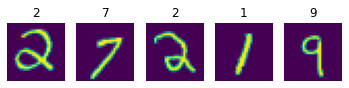

In [6]:
sample_indicies = [random.randint(0, train_x.shape[0]-1) for _ in range(5)]
fig, ax = plt.subplots(1, 5, figsize=(6,2))
for i,a in enumerate(ax):
  a.imshow(train_x[sample_indicies[i]])
  a.axis('off')
  a.set_title(train_y[sample_indicies[i]])  # provide true label
plt.show()

# Time to work on the Generative Adversarial Network (GAN)
Firstly, let's define the descriminator which tries to work out which data is 'real' and which has been generated

In [7]:
def create_discriminator(dims=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr = 0.0005, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [8]:
def create_generator(latent_dim):
  model = Sequential()
  model.add(Dense(128*24*24, input_dim=latent_dim))
  model.add(Reshape((24, 24, 128)))
  model.add(Conv2DTranspose(128, (3,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (3,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))
  return model

In [9]:
# Combine generator and discriminator to create the gan
def create_gan(gen, disc):
  disc.trainable = False  # Ensure discriminator isn't updated during generator update
  model = Sequential()
  model.add(gen)
  model.add(disc)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [10]:
def get_real_samples(dset, n):  # get n samples from dataset
  ix = np.random.randint(0, dset.shape[0], n)
  X = dset[ix]
  Y = np.ones((n, 1))  # One label for 'real' samples
  return X, Y

In [11]:
def get_latent_points(latent_dim, n):
  x_input = np.random.randn(latent_dim * n)  # n normally distributed samples
  x_input = x_input.reshape(n, latent_dim)  # reshape to fit latent space
  return x_input

In [12]:
def get_fake_samples(generator, latent_dim, n):
  x_input = get_latent_points(latent_dim, n)
  X = generator.predict(x_input)  # Run through generator
  Y = np.zeros((n, 1))  # Zero label for 'fake' sample
  return X, Y

We need to prepare the data for training

In [13]:
X = np.expand_dims(train_x, axis=-1)  # Even though its b&w image need 3rd channel
X = X.astype('float32')  # Needs to be float for rescaling
X = X / 255.0  # Rescale between 0 and 1

In [ ]:
generator = create_generator(100)
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)
gan.summary()  # Print model summaryin

In [30]:
# Train (or retrain) here
n_epochs = 30  # I've found after 30 epochs you get some pretty decent generated images
batch_size = 256
bat_per_epoch = int(X.shape[0] / batch_size)
half_bat = int(batch_size/2)

for i in range(n_epochs):
  for j in range(bat_per_epoch):
    x_real, y_real = get_real_samples(X, half_bat)
    x_fake, y_fake = get_fake_samples(generator, 100, half_bat)
    x_dis, y_dis = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
    dis_loss, _ = discriminator.train_on_batch(x_dis, y_dis)

    x_gan = get_latent_points(100, batch_size)
    y_gan = np.ones((batch_size, 1))  # Need 'inverted' label as we are trying to train generator to trick discriminator
    gan_loss = gan.train_on_batch(x_gan, y_gan)  # Update GAN, in reality only updates weights of generator
    
  # End of each epoch print loss stats and eval performance
  print(f'Epoch: {i}, Discriminator loss: {dis_loss:.3f}, gan loss: {gan_loss:.3f}')
  x_real, y_real = get_real_samples(X, half_bat)
  x_fake, y_fake = get_fake_samples(generator, 100, half_bat)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake)
  _, acc_real = discriminator.evaluate(x_real, y_real)
  print(f'Accuracy Real: {100*acc_real:.0f}%  Fake:{100*acc_fake:.0f}%')

Epoch: 0, Discriminator loss: 0.656, gan loss: 0.659
4/4 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.8906
Accuracy Real: 89%  Fake:48%
Epoch: 1, Discriminator loss: 0.649, gan loss: 0.981
4/4 [==============================] - 0s 2ms/step - loss: 0.8010 - accuracy: 0.2578
Accuracy Real: 26%  Fake:98%
Epoch: 2, Discriminator loss: 0.637, gan loss: 0.685
4/4 [==============================] - 0s 2ms/step - loss: 0.5781 - accuracy: 0.7500
Accuracy Real: 75%  Fake:55%
Epoch: 3, Discriminator loss: 0.647, gan loss: 0.756
4/4 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.6875
Accuracy Real: 69%  Fake:77%
Epoch: 4, Discriminator loss: 0.641, gan loss: 0.923
4/4 [==============================] - 0s 2ms/step - loss: 0.8219 - accuracy: 0.2891
Accuracy Real: 29%  Fake:99%
Epoch: 5, Discriminator loss: 0.649, gan loss: 0.978
4/4 [==============================] - 0s 2ms/step - loss: 0.8228 - accuracy: 0.2266
Accuracy Real: 23%  Fake:99

Finally, let's generate some images after some training

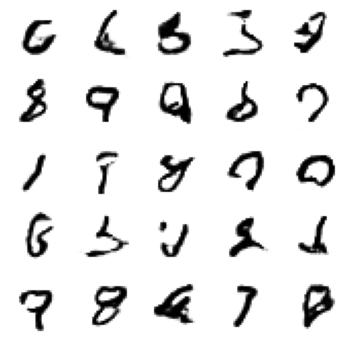

In [31]:
n_images = 25  # Images to generate
latent_dim = 100  # Latent space of generator
latent_points = np.random.randn(latent_dim * n_images)
x_input = latent_points.reshape(n_images, latent_dim)
generated_images = generator.predict(x_input)

fig, ax = plt.subplots(5, 5, figsize=(6,6))
for i in range(n_images):
  ax[i%5][math.floor(i/5)].imshow(generated_images[i,:,:,0], cmap='gray_r')
  ax[i%5][math.floor(i/5)].axis('off')
plt.show()